<a href="https://colab.research.google.com/github/ASerraMartin/SAC_Spark/blob/main/SAC_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports and Spark environment setup**

In [88]:
from pyspark import SparkContext, SparkConf
from string import ascii_uppercase
import matplotlib.pyplot as plt
import networkx as nx
import random

### **Auxiliary functions**

In [89]:
def plot_graph(G):
  """
  Plots the given directed graph G, naming each node and showing every directed edge and its associated weight.
  """

  # Establish a general purpose layout for any graph
  layout = nx.circular_layout(G)

  # Plot the nodes
  nx.draw_networkx_nodes( G, layout, node_color= 'lightblue', node_size=300)
  nx.draw_networkx_labels(G, layout)

  # Plot the edges
  nx.draw_networkx_edges(G, layout, edge_color='gray', width=0.5)
  nx.draw_networkx_edge_labels(G, layout, edge_labels=nx.get_edge_attributes(G, 'weight'))

  plt.show()

In [90]:
def generate_random_graph(n, p, weight_range):
  """
  Generates a random directed graph, with n nodes, p probability of connection between node pairs
  and random edge weights whitin the specified range (weight_range).
  """

  # Generate the random directed graph, with numbers as node names
  G_numbers = nx.gnp_random_graph(n, p, directed=True)

  # Map the node names to letters, ordered alphabetically
  mapping = {i: ascii_uppercase[i] for i in range(n)}
  G_letters = nx.relabel_nodes(G_numbers, mapping)

  # Add random weights within the specified range to the edges
  for (u, v) in G_letters.edges():
    G_letters.edges[u, v]['weight'] = int(random.randint(*weight_range))

  return G_letters

Graph generator extracted from:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html

In [91]:
def preprocess_pyspark_graph(G, source_node):
  """
  Converts a NetworkX graph G into a list format compatible with PySpark. The specified
  source node will serve as the initial node for the Dijkstra shortest-path algorithm.
  """

  pyspark_graph = []

  for node in G.nodes():
    # Get a tuple list of (neighbor, weight) for all neighboring nodes
    neighbors = [(nbr, G.edges[node, nbr]["weight"]) for nbr in G.successors(node)]

    # Initialize the node's distance (0 for the source, infinite otherwise)
    initial_weight = 0 if node == source_node else float("inf")

    # Establish the node's initial state
    state = (
        neighbors,
        initial_weight,
        False, # Not processed
        [],    # No history of visited nodes
    )

    pyspark_graph.append((node, state))

  return pyspark_graph

### **Initial graph**

#### Generation

In [92]:
# Example graph
G = nx.DiGraph()
G.add_weighted_edges_from([
    ("A", "B", 3), ("A", "C", 10), ("A", "E", 4),
    ("B", "C", 2), ("B", "D", 8),  ("B", "F", 7),
    ("C", "D", 5), ("C", "G", 3),
    ("D", "H", 6),
    ("E", "F", 2), ("E", "I", 9),
    ("F", "G", 1), ("F", "J", 5),
    ("G", "H", 2), ("G", "K", 4),
    ("I", "J", 3),
    ("J", "K", 6)
])

# Example of a randomly generated graph
G2 = generate_random_graph(10, 0.15, (1, 10))

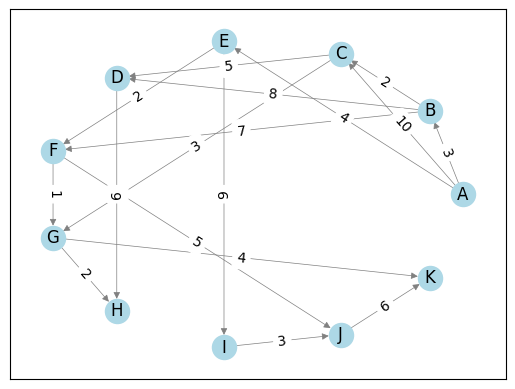

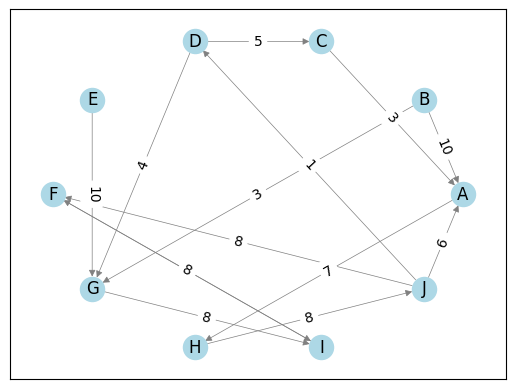

In [93]:
plot_graph(G)
plot_graph(G2)

#### Pre-processing

In [94]:
pyspark_graph = preprocess_pyspark_graph(G, "A")
pyspark_graph2 = preprocess_pyspark_graph(G2, "A")

In [95]:
for city in pyspark_graph:
    print(city)

print("\n\n\n")

for city in pyspark_graph2:
  print(city)

('A', ([('B', 3), ('C', 10), ('E', 4)], 0, False, []))
('B', ([('C', 2), ('D', 8), ('F', 7)], inf, False, []))
('C', ([('D', 5), ('G', 3)], inf, False, []))
('E', ([('F', 2), ('I', 9)], inf, False, []))
('D', ([('H', 6)], inf, False, []))
('F', ([('G', 1), ('J', 5)], inf, False, []))
('G', ([('H', 2), ('K', 4)], inf, False, []))
('H', ([], inf, False, []))
('I', ([('J', 3)], inf, False, []))
('J', ([('K', 6)], inf, False, []))
('K', ([], inf, False, []))




('A', ([('H', 7)], 0, False, []))
('B', ([('A', 10), ('G', 3)], inf, False, []))
('C', ([('A', 3)], inf, False, []))
('D', ([('C', 5), ('G', 4)], inf, False, []))
('E', ([('G', 10)], inf, False, []))
('F', ([('I', 6)], inf, False, []))
('G', ([('I', 8)], inf, False, []))
('H', ([('J', 8)], inf, False, []))
('I', ([('F', 8)], inf, False, []))
('J', ([('A', 6), ('D', 1), ('F', 8)], inf, False, []))
